mostafa egbaria - 206384919

mostafa jbareen - 212955587

# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [1]:
!pip install jedi==0.10
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

  Using cached stable_baselines3-2.2.1-py3-none-any.whl (181 kB)
  Using cached ale_py-0.7.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Using cached Shimmy-1.3.0-py3-none-any.whl (37 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
  Using cached stable_baselines3-2.1.0-py3-none-any.whl (178 kB)
  Using cached Shimmy-1.1.0-py3-none-any.whl (37 kB)
  Using cached stable_baselines3-2.0.0-py3-none-any.whl

In [2]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import math
import random

import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions
import torch.nn.functional as F

from google.colab import files
from torchsummary import summary
from torchvision import models

# if gpu is to be utilized
if torch.cuda.is_available():
  print("Executing with GPU")
else:
  print("Running without GPU")


# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # If available, set the device to GPU
    device = torch.device("cuda")
else:
    # If not available, set the device to CPU
    device = torch.device("cpu")

# Check if the "DISPLAY" environment variable is not set or empty
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    # If true, install xvfb (X Virtual Framebuffer) quietly
    !apt-get -qq install -y xvfb
    # Set the "DISPLAY" environment variable to ':1'
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


Executing with GPU
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected 

## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones.

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/Breakout).



observation dim (210, 160, 3) number of actions 4


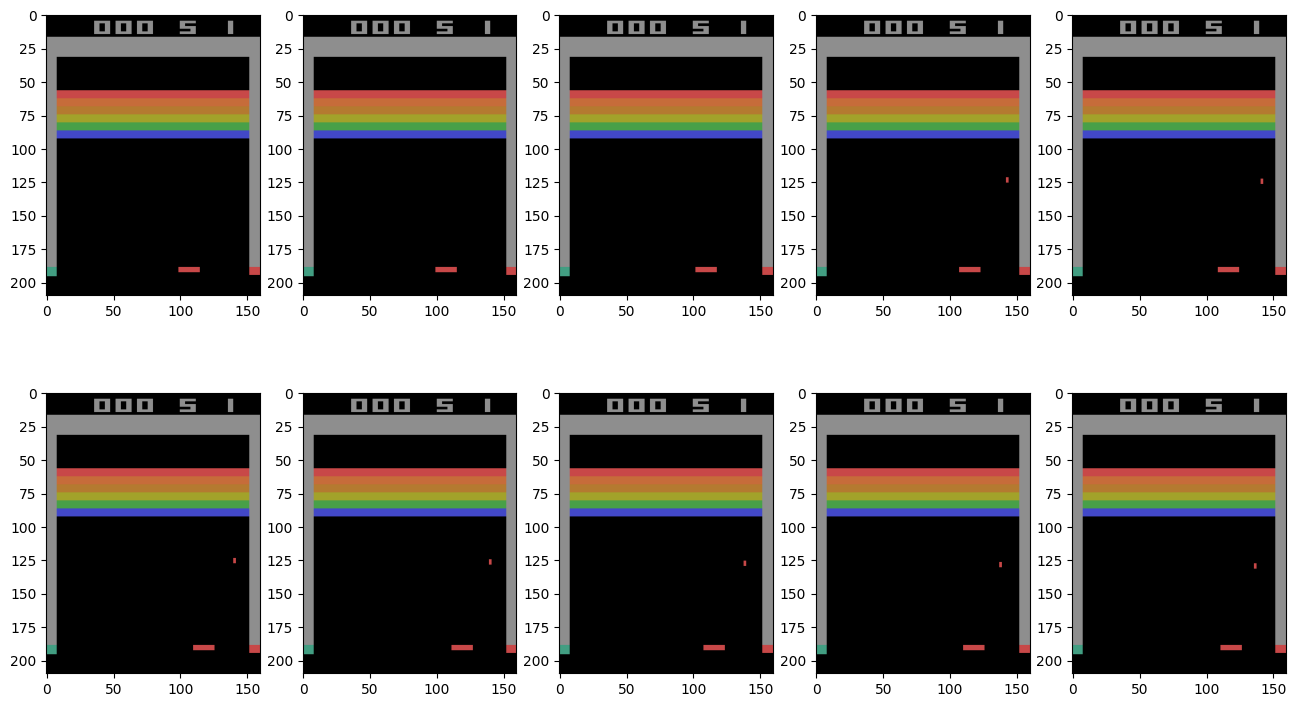

In [3]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [4]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

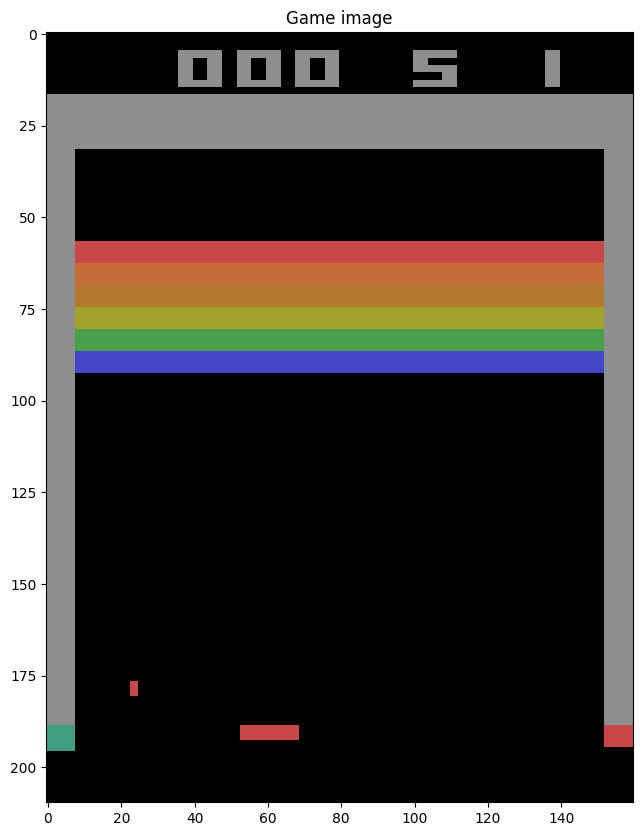

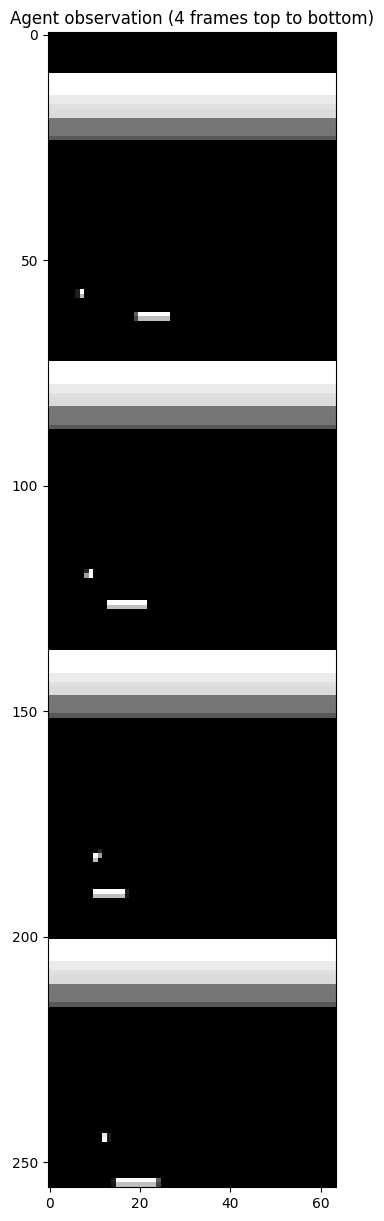

In [5]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

# Replay Buffer

In [6]:
# Defining the transition as a tuple.
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

# A replay memory class for storing and sampling transitions
class ReplayMemory(object):

    def __init__(self, capacity):
      """
        Initialize the replay memory with a specified capacity.

        Parameters:
        - capacity (int): The maximum capacity of the replay memory.
      """

      self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward):
      """Add a transition to the replay memory."""
      new_transition = Transition(state, action, next_state, reward)
      self.memory.append(new_transition)

    def __len__(self):
        return len(self.memory)

    # Sample randomly from memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


# DQN model

In [8]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        channels, _, _ = input_dim

        # Define convolutional layers
        conv1 = nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=2)
        conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Sequential layer containing convolutional layers with ReLU activations
        self.l1 = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
            nn.ReLU(),
            conv3,
            nn.ReLU()
        )

        # Calculate output dimensions for linear layer
        conv_output_size = self.conv_output_dim()
        lin1_output_size = 512

        # Define fully connected layers
        fc1 = nn.Linear(conv_output_size, lin1_output_size)
        fc2 = nn.Linear(lin1_output_size, output_dim)

        # Sequential layer containing fully connected layers with ReLU activation
        self.l2 = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2
        )

    # Calculate output dimension of convolutional layers
    def conv_output_dim(self):
        x = torch.zeros(1, *self.input_dim)
        x = self.l1(x)
        return int(np.prod(x.shape))

    # Performs forward pass through the network, returns action values
    def forward(self, x):
        x = self.l1(x)  # Pass input through convolutional layers
        x = x.view(x.shape[0], -1)  # Flatten the output of convolutional layers
        actions = self.l2(x)  # Pass flattened output through fully connected layers
        return actions

# Assuming env and n_actions are defined elsewhere
obs, _, _, _ = env.step(env.action_space.sample())
env.reset()

# Display shape of observation and number of actions
print(obs.shape)
print(n_actions)

# Create an instance of DQN model and move it to GPU if available
tmp_model = DQN(obs.shape, n_actions).cuda()

# Display model summary using torchsummary
summary(tmp_model, (4,64,64))

(4, 64, 64)
4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           8,224
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,832
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
              ReLU-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 512]       2,097,664
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 4]           2,052
Total params: 2,177,700
Trainable params: 2,177,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.26
Params size (MB): 8.31
Estimated Total Size (MB): 8.63
-------------------------

# DQN Agent

In [9]:
#Deep Q-learning Agent with target and policy neural networks.
class DQNAgent():
    def __init__(self, action_count, target_network, policy_network):
      # Initialize the DQNAgent with the number of possible actions,
      # target neural network, and policy neural network.
      self.target_net = target_network
      self.num_actions = action_count
      self.policy_net = policy_network

    def get_qvalues(self, input_states):
        """Get Q-values for a batch of states from the policy network."""

        # Convert input states to a PyTorch tensor
        input_states_tensor = torch.tensor(input_states, device=device)

        # Get Q-values from the policy network
        q_values = self.policy_net(input_states_tensor.to(torch.float32))

        # Detach the computation graph and convert to NumPy array
        return q_values.detach().cpu().numpy()

    def update_target_network(self):
      # Update the target neural network by loading the state dictionary
      # from the policy neural network.
      print("Updating target network.")
      self.target_net.load_state_dict(self.policy_net.state_dict())
      return

    def sample_actions(self, state, sample_only):
        global steps_done

        # If sampling only, choose a random action
        if sample_only:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

        # Explore vs. exploit based on epsilon-greedy strategy
        sample = random.random()
        epsilon_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        epsilon_values.append(epsilon_threshold)

        # Choose action based on epsilon-greedy strategy
        if sample > epsilon_threshold:
            # Exploitation: Select the action with the maximum Q-value
            with torch.no_grad():
                return self.policy_net(state).argmax(1).view(1, 1)
        else:
            # Exploration: Select a random action
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


    def save_current_model(self):
        # Display a message indicating that the current best model is being saved
        print("Saving the current best model!")

        # Save the state dictionary of the policy network
        policy_state_dict = self.policy_net.state_dict()
        torch.save(policy_state_dict, 'policy_checkpoint.pth')


# Evaluate

In [10]:
def evaluate(environment, agent, num_games=1, greedy=False, max_steps=20000, visualize=False, restart_environment=False, verbose_end_game=False):
    # Check if environment restart is requested
    if restart_environment:
        environment = make_env()

    # Plays num_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward.
    game_rewards = []
    for _ in range(num_games):
        visual = visualize
        state = environment.reset()
        total_reward = 0

        for step_count in range(max_steps):
            with torch.no_grad():
                q_values = agent.get_qvalues([state])

            # Choose action based on Q-values
            if greedy:
                action = q_values.argmax(axis=-1)[0]
            else:
                state_batch = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = agent.sample_actions(state_batch, sample_only=False)[0]

            state, reward, done, _ = environment.step(action)

            # Visualization
            if visual and step_count % 2 == 0:
                # Reshape the state for visualization
                reshaped_state = state.reshape([-1, state_shape[2]])

                # Display a subset (64 rows) of the reshaped state using a grayscale colormap
                plt.figure(figsize=[5, 5])
                plt.imshow(reshaped_state[:64, :], cmap='gray')

                # Show the visualization
                plt.show()

            # if near max steps, turn on visualization
            if step_count > (max_steps - 10):
                visual = True

            total_reward += reward
            if done:
                break

        if verbose_end_game:
            # Print the reward obtained at the end of the game
            print("Game reward at the end of the episode:", total_reward)

            # Display the final state for visual inspection
            print("Final state visualization:")
            plt.figure(figsize=[5, 5])

            # Display a subset (64 rows) of the final state using a grayscale colormap
            plt.imshow(state.reshape([-1, state_shape[2]])[:64, :], cmap='gray')

            # Show the visualization
            plt.show()

        # check if reached max steps
        if step_count > (max_steps - 10):
            print(f"WARNING: Maximum steps reached. Current reward: {total_reward}")

        game_rewards.append(total_reward)
    return np.mean(game_rewards)


# Create / Load models

In [11]:

# LOAD_PREV_MODEL: Determine whether to load a previously saved model or not
LOAD_PREV_MODEL = True #@param ["False", "True"] {type:"raw"}

# INIT: Determine whether to initialize the weights of the model
INIT = False #@param ["False", "True"] {type:"raw"}

# init_thresh: Threshold for weight initialization
init_thresh = 0.025

# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
obs, _, _, _ = env.step(env.action_space.sample())
n_observations = obs.shape

# Initialize target and policy DQN networks with the specified observations and actions
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)



if LOAD_PREV_MODEL:
    print("LOADING MODELS")
    # Load previously saved models from the 'policy_checkpoint.pth' file
    # This allows continuing training from a previously saved state
    target_state_dict = torch.load('policy_checkpoint.pth')
    target_net.load_state_dict(target_state_dict)
    policy_net.load_state_dict(target_state_dict)

else:
  # Load or initialize target and policy networks
  target_net.load_state_dict(policy_net.state_dict())

  # Initialize weights if specified
  if INIT:
      stop_init = False

      # Continue initializing until a suitable initialization is found
      while not stop_init:
          # Load model or create new instances
          target_net = DQN(n_observations, n_actions).to(device)
          policy_net = DQN(n_observations, n_actions).to(device)
          agent = DQNAgent(n_actions,target_net,policy_net)

          # Get Q-values for the initial state
          s = env.reset()
          qvalues = agent.get_qvalues([s])

          # Check conditions for a valid initialization
          if np.min(qvalues[0]) > 0 and (np.max(qvalues[0]) - np.min(qvalues[0])) < init_thresh:
              stop_init = True
              print("Q-values range for initialization:", np.max(qvalues[0]) - np.min(qvalues[0]))
              print("Maximum Q-value for initialization:", np.max(qvalues[0]))

      # Copy weights from the initialized networks to both target and policy networks
      policy_net.load_state_dict(target_net.state_dict())
      agent = DQNAgent(n_actions, target_net, policy_net)

      # Evaluate the mean reward for the initialized models
      mean_reward = evaluate(env, agent, greedy=True, num_games=2)
      print("Mean reward for initialized models:", mean_reward)

  print("Using new models!")

LOADING MODELS


# Hyper Parameters

In [ ]:
# Discount factor for future rewards
GAMMA = 0.99

# Number of transitions sampled from the replay buffer
BATCH_SIZE = 32

# Initial value of epsilon for exploration
EPS_START = 0.5

# Final value of epsilon for exploration
EPS_END = 0.01

# Update rate of the target network
TAU = 0.0005

# Rate of exponential decay for epsilon, higher means slower decay
EPS_DECAY = 2000000

# Learning rate for the AdamW optimizer
LR = 1e-4

# Frequency of updating the target network weights
UPDATE_FREQUENCY = 1000

# Total number of episodes for training
EPISODES = 50000

# Number of episodes to record samples for replay memory
RECORD_SAMPLES = 150000  # (episodes)

# Size of the replay memory
MEMORY_SIZE = 175000  # (samples)

# Counter to keep track of learning iterations
LEARNING_COUNTER = 0


#Utilities


In [12]:
# Get the number of possible actions from the environment's action space
n_actions = env.action_space.n

# Get the shape of the state observations by taking a sample step in the environment
obs, _, _, _ = env.step(env.action_space.sample())
n_observations = obs.shape

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)
# create agent
agent = DQNAgent(n_actions,target_net,policy_net)

# data lists
curr_best_model = None
current_max_reward = 0
steps_done = 0
epsilon_values = []
episode_durations = []
losses_epochs = []
scores_epochs = []
rewards_evaluations = []

def select_action(state, sample_only):
    global steps_done

    # If sample_only is True, choose a random action
    if sample_only is True:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    # Exploration-exploitation strategy using epsilon-greedy
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    epsilon_values.append(eps_threshold)

    # Exploit if sample is greater than epsilon, else explore
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated


def plot_loss(losses):
    # Plot the loss over iterations
    plt.plot(np.arange(len(losses)), losses, color='r')
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title('Loss Function Plot')
    plt.show()

def plot_rewards(rewards, color):
    # Scatter plot for rewards over iterations
    plt.scatter(np.arange(len(rewards)), rewards, marker='x', color=color)
    plt.xlabel('Number of iterations')
    plt.ylabel('Rewards')
    plt.title('Rewards Function Plot')
    plt.show()

def plot_epsilon(eps):
    # Plot the epsilon values over training iterations
    plt.plot(np.arange(len(eps)), eps, color='k')
    plt.xlabel('Number of iterations')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Function Plot')
    plt.show()


def fill_memory_buffer():
    # Record memory samples until reaching the desired number
    while len(memory) < RECORD_SAMPLES:
        print(len(memory))
        done = False
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        terminated = False

        # Collect transitions until the episode is terminated
        while not terminated:
            # Select an action using epsilon-greedy strategy (exploration)
            action = select_action(state, sample_only=True)

            # Take the selected action and observe the next state and reward
            next_state, reward, terminated, truncated = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # Convert the next state to tensor format
            next_state = None if terminated else torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in the replay memory
            memory.push(state, action, next_state, reward)


# Training

In [ ]:
def optimize_model(agent):
    global LEARNING_COUNTER
    losses = []

    # Check if the replay memory has enough samples for a batch
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions from the replay memory
    transitions = memory.sample(BATCH_SIZE)

    # Separate the components of the transitions into individual batches
    batch = Transition(*zip(*transitions))

    # Create a mask to identify non-final next states
    #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=device, dtype=torch.bool)

    # Concatenate non-final next states for efficient computation
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # Concatenate state, action, and reward batches
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Calculate Q-values for the current state-action pairs using the policy network
    state_action_values = agent.policy_net(state_batch).gather(1, action_batch)

    # Initialize next state values with zeros for all samples
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Update next state values for non-final states using the target network
    with torch.no_grad():
        next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1)[0]

    # Calculate expected state-action values using the Bellman equation
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Use SmoothL1Loss as the criterion for updating the neural network
    criterion = nn.SmoothL1Loss()

    # Calculate the loss using the Smooth L1 Loss criterion
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Zero the gradients to avoid accumulation
    optimizer.zero_grad()

    # Backpropagate the loss and update the neural network weights
    loss.backward()
    optimizer.step()

    # Append the current loss to the list for monitoring
    losses.append(loss)

    # Increment the learning counter
    LEARNING_COUNTER += 1

    # Return the list of losses for monitoring
    return losses





############################ TRAINING LOOP ##############################

# Populate the memory buffer with random samples
fill_memory_buffer()

# Training loop for episodes
for episode in range(EPISODES):
    # Initialize lists to store losses and rewards for each episode
    losses = []
    rewards = []

    # Reset the environment for a new episode
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    terminated = False
    steps_count = 0
    episode_score = 0

    # Episode main loop
    while not terminated:
        # Choose an action using the epsilon-greedy strategy
        action = agent.sample_actions(state, sample_only=False)
        next_state, reward, terminated, truncated,  = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        rewards.append(reward)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        steps_count += 1
        episode_score += reward

        # Optimize the model every 4 steps
        if steps_count % 4 == 0:
            loss = optimize_model(agent=agent)
            losses.append(loss)

    # Update the target network every UPDATE_FREQUENCY episodes
    if episode > 0 and episode % UPDATE_FREQUENCY == 0:
        agent.update_target_network()

    # Evaluate the model every episode
    if episode % 1 == 0:
        mean_reward = evaluate(env, agent, num_games=1, greedy=True, visualize=False, restart_environment=True, verbose_end_game=False)
        rewards_evaluations.append(mean_reward)

        # Save the current model if it achieves a new maximum reward
        if mean_reward > current_max_reward:
          current_max_reward = mean_reward
          agent.save_current_model()

    # Process losses
    if not all(l is None for l in losses):
      losses = [x for x in losses if x is not None]
      losses_np = torch.tensor(losses).detach().cpu().numpy()
      losses_epochs.append(losses_np.mean())

    # Process scores
    scores_epochs.append(episode_score.cpu())
    scores_array = np.empty(len(scores_epochs), dtype=object)
    for i in range(len(scores_epochs)):
      scores_array[i] = np.array(scores_epochs[i])

    # Plotting
    if episode % 100 == 0:
      print("Episode: ", episode)
      # plot_epsilon(epsilon_values)
      # plot_rewards(np.array(rewards_evaluations), 'c')
      # plot_rewards(scores_array, 'g')
      plot_loss(np.array(losses_epochs))

print('Training Complete')
agent.update_target_network()
plot_epsilon(epsilon_values)
plot_rewards(scores_array, 'g')
plot_rewards(np.array(rewards_evaluations), 'c')
plot_loss(np.array(losses_epochs))
plt.ioff()
plt.show()

# Plots

*Note-
Unfortunately, Colab crashes occurred several times during our training sessions, posing challenges for running extended training sessions. To address this issue, we decided to split our runs into separate sessions. Consequently, the plots are presented in two consecutive blocks corresponding to their respective running orders.*

## Plots explanation:

**Green plot** - reward as function of training episode

X-axis: training episodes

Y-axis: reward

**Blue plot** - evaluated reward as function of training episodes

X-axis: training episodes in jumps of 20

Y-axis: reward


**Red plot** - Loss as a function of training episodes

X-axis: training episodes

Y-axis: loss function

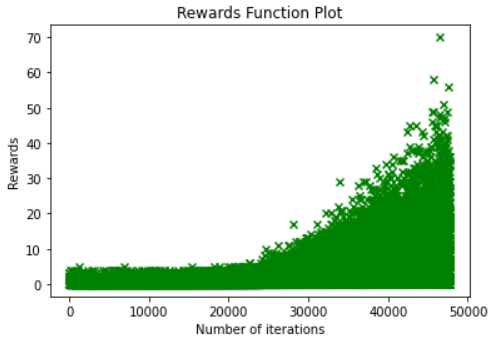

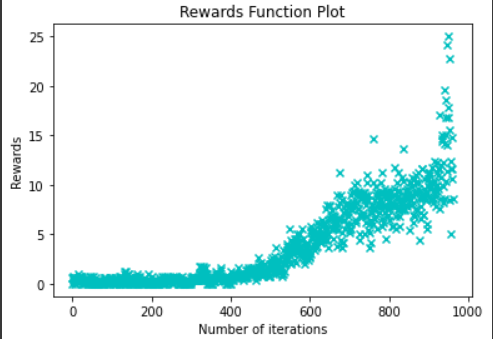


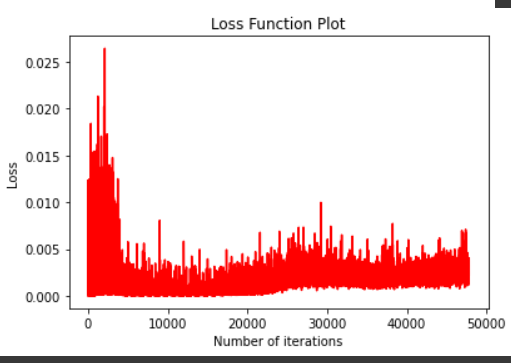

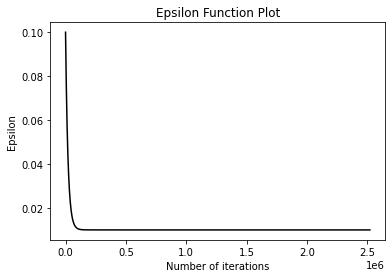

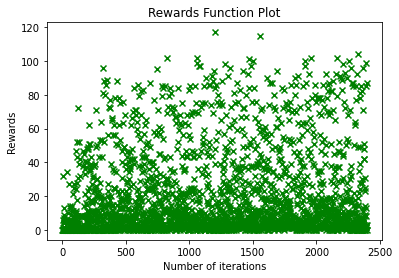

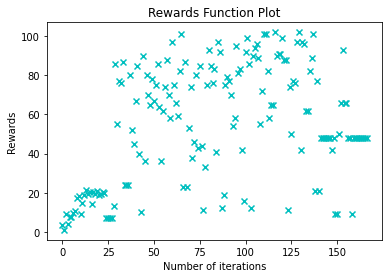

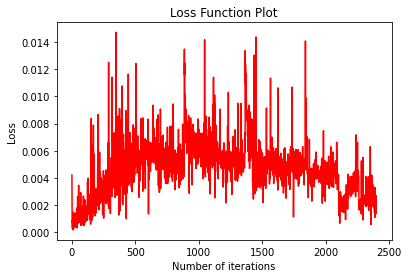

In [ ]:
# plot the rest from this execution
plot_epsilon(epsilon_values)
plot_rewards(scores_array, 'g')
plot_rewards(np.array(rewards_evaluations), 'c')
plot_loss(np.array(losses_epochs))
plt.ioff()
plt.show()

# Upload a model for inference

In [ ]:
LOAD_MODEL_FOR_INFERENCE = True#@param ["False", "True"] {type:"raw"}
UPLOAD_FILES = True#@param ["False", "True"] {type:"raw"}
if LOAD_MODEL_FOR_INFERENCE is True:
  if UPLOAD_FILES:
    files.upload()
  agent = DQNAgent(n_actions,target_net,policy_net)
  print("LOADING MODELS")
  target_state_dict = torch.load('policy_checkpoint.pth')
  agent.target_net.load_state_dict(target_state_dict)
  agent.policy_net.load_state_dict(target_state_dict)
  env = make_env()
  mean_reward = evaluate(env, agent, greedy=True, num_games=1, visualize= False, restart_environment = False, verbose_end_game=True)
  print(mean_reward)


## SAVE model

In [ ]:
from google.colab import files
SAVE_MODEL = True #@param ["False", "True"] {type:"raw"}
DOWNLOAD_MODEL = True #@param ["False", "True"] {type:"raw"}
if SAVE_MODEL is True:
  torch.save(target_net.state_dict(), 'target_checkpoint.pth')
  torch.save(policy_net.state_dict(), 'policy_checkpoint.pth')
if DOWNLOAD_MODEL is True:
  files.download('target_checkpoint.pth')
  files.download('policy_checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

## Video generation

Game reward at the end of the episode: 102.0
Final state visualization:


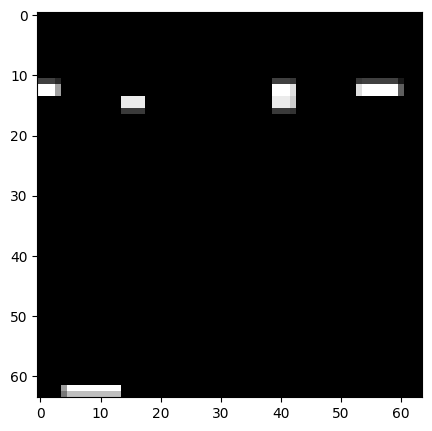

In [17]:
# run sessions
import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

# Running the model with 1 live only for 1 game
#tmp_env = make_env()
with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    #env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, num_games=1, greedy=True,visualize=False, restart_environment = False, verbose_end_game=True) for _ in range(1)]




In [18]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A nerual network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.